In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.shape

(10000, 14)

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
y = df.iloc[:,13]
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [5]:
X = df.iloc[:,3:13]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


<Axes: ylabel='count'>

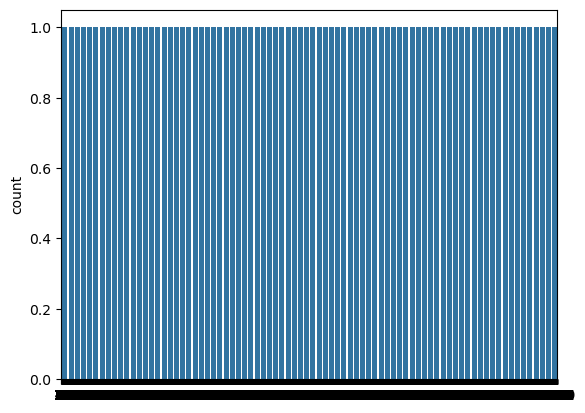

In [6]:
sns.countplot(y)

<Axes: xlabel='count', ylabel='Geography'>

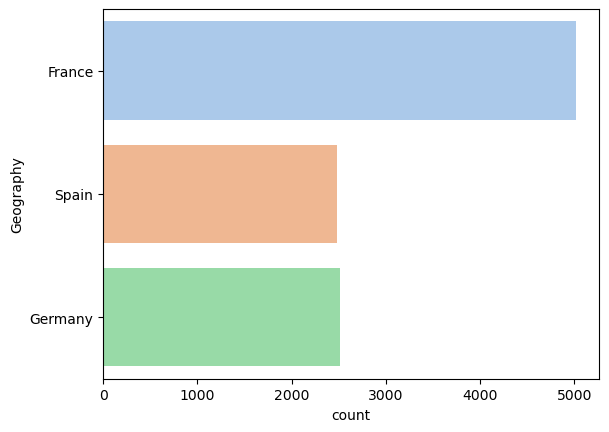

In [7]:
sns.countplot(X['Geography'],palette='pastel')

Gender
Male      5457
Female    4543
Name: count, dtype: int64


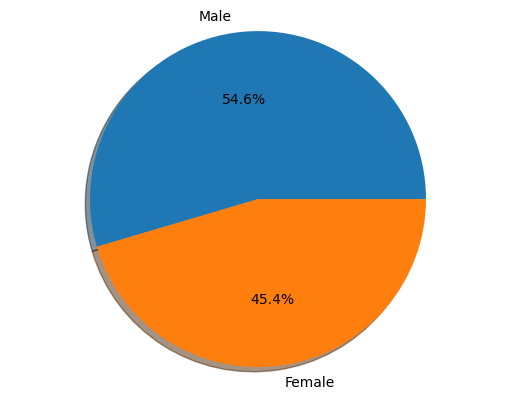

In [8]:
labels = ['Male','Female']
sizes = X['Gender'].value_counts()
print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

<Axes: xlabel='Geography', ylabel='Exited'>

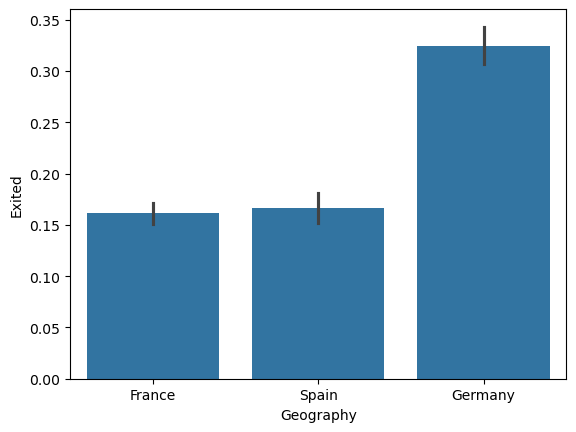

In [9]:
sns.barplot(x='Geography', y='Exited', data=df)

<Axes: xlabel='Gender', ylabel='Exited'>

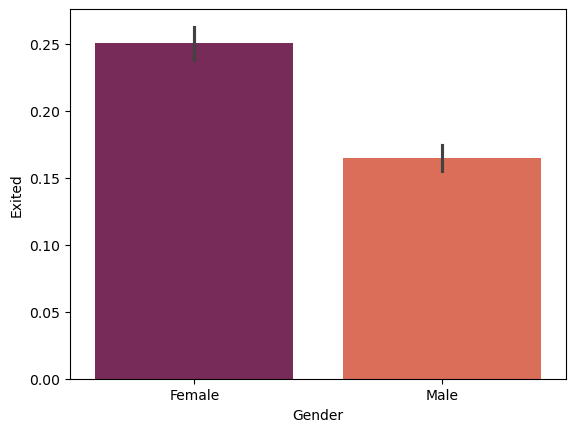

In [10]:
sns.barplot(x='Gender', y='Exited', data=df,palette='rocket')

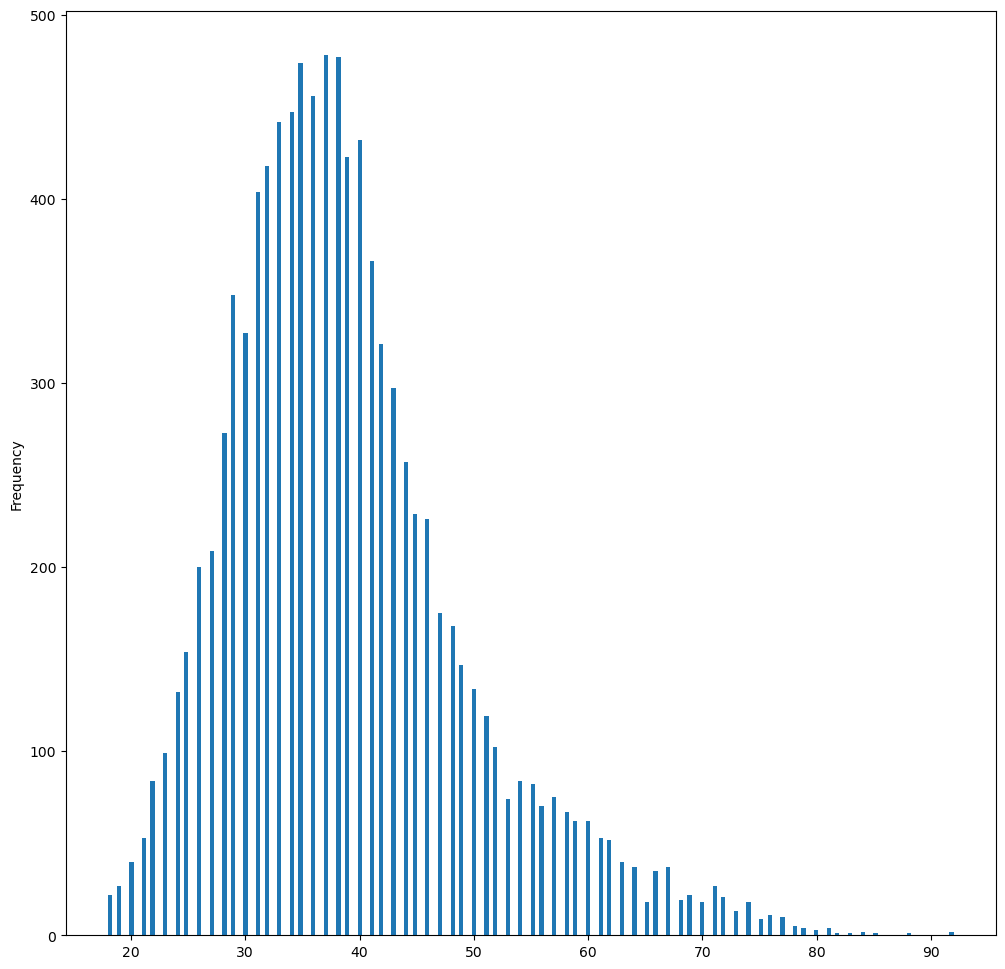

In [11]:
df.Age.plot(kind = 'hist', bins = 200, figsize = (12,12))
plt.show()

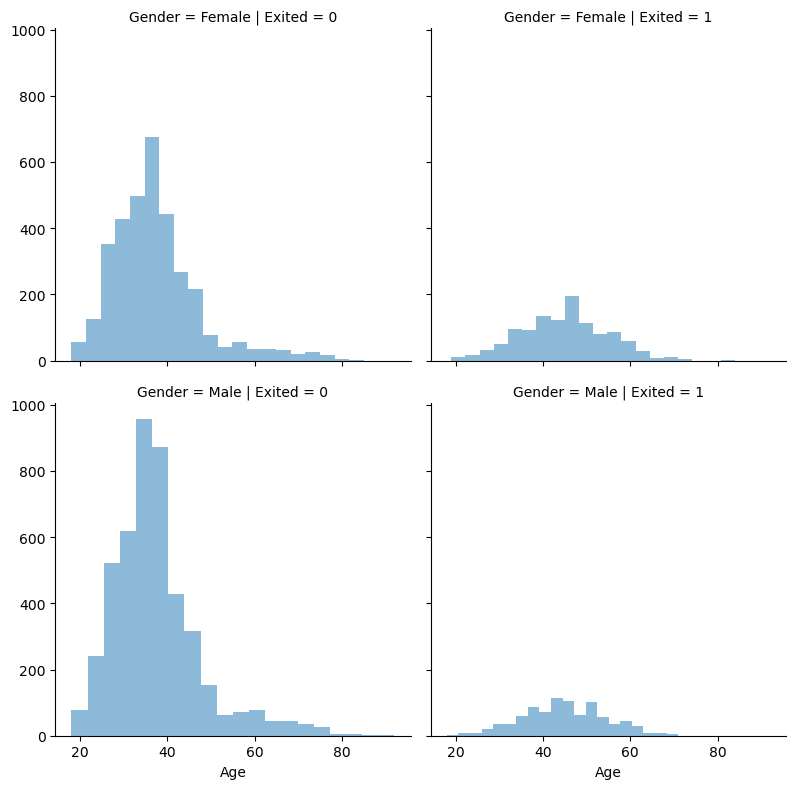

In [12]:
g = sns.FacetGrid(df, row='Gender', col='Exited', height=4)
g.map(plt.hist,'Age', alpha=0.5, bins=20)
g.add_legend()
plt.show()

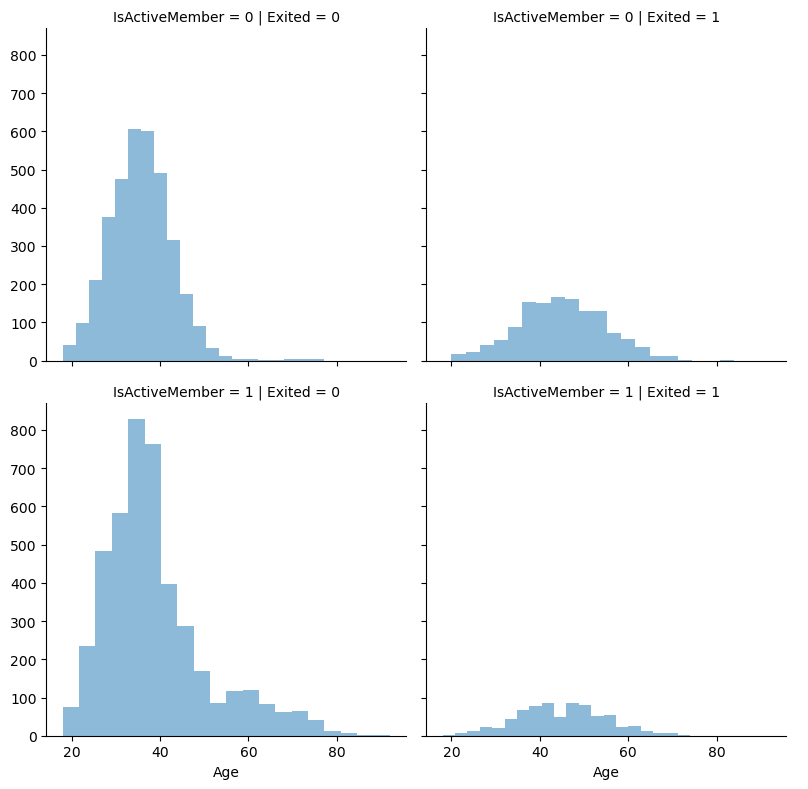

In [13]:
g = sns.FacetGrid(df, row='IsActiveMember', col='Exited', height=4)
g.map(plt.hist,'Age', alpha=0.5, bins=20)
g.add_legend()
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
label = LabelEncoder()
X['Gender'] = label.fit_transform(X['Gender'])
print(X['Gender'].head(7))

0    0
1    0
2    0
3    0
4    0
5    1
6    1
Name: Gender, dtype: int64


In [15]:
X['Geography']=label.fit_transform(X['Geography'])
print(X['Geography'].head())
X['Geography'].value_counts()

0    0
1    2
2    0
3    0
4    2
Name: Geography, dtype: int64


Geography
0    5014
1    2509
2    2477
Name: count, dtype: int64

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np


geography_data = X.iloc[:, 1].values.reshape(-1, 1)

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

geography_encoded = onehot_encoder.fit_transform(geography_data)

X_temp = X.drop(columns=['Geography']).values

X = np.concatenate((geography_encoded, X_temp), axis=1)

print(X[0:5])

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 6.1900000e+02 0.0000000e+00
  4.2000000e+01 2.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00
  1.0000000e+00 1.0134888e+05]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 6.0800000e+02 0.0000000e+00
  4.1000000e+01 1.0000000e+00 8.3807860e+04 1.0000000e+00 0.0000000e+00
  1.0000000e+00 1.1254258e+05]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 5.0200000e+02 0.0000000e+00
  4.2000000e+01 8.0000000e+00 1.5966080e+05 3.0000000e+00 1.0000000e+00
  0.0000000e+00 1.1393157e+05]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 6.9900000e+02 0.0000000e+00
  3.9000000e+01 1.0000000e+00 0.0000000e+00 2.0000000e+00 0.0000000e+00
  0.0000000e+00 9.3826630e+04]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 8.5000000e+02 0.0000000e+00
  4.3000000e+01 2.0000000e+00 1.2551082e+05 1.0000000e+00 1.0000000e+00
  1.0000000e+00 7.9084100e+04]]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.35,random_state=42)

In [19]:
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

In [20]:
X_train

array([[-1.00462608, -0.56905968,  1.71795453, ...,  0.64722807,
         0.96581473,  0.56276126],
       [-1.00462608, -0.56905968,  1.71795453, ...,  0.64722807,
         0.96581473, -1.58504165],
       [ 0.99539522, -0.56905968, -0.58208758, ...,  0.64722807,
        -1.03539526, -1.07751299],
       ...,
       [ 0.99539522, -0.56905968, -0.58208758, ..., -1.54505043,
        -1.03539526, -0.1530867 ],
       [ 0.99539522, -0.56905968, -0.58208758, ...,  0.64722807,
        -1.03539526, -0.06146547],
       [-1.00462608,  1.75728493, -0.58208758, ...,  0.64722807,
         0.96581473, -0.82256561]])

In [21]:
X_test

array([[-1.00462608,  1.75728493, -0.58208758, ..., -1.54505043,
        -1.03539526, -1.02689323],
       [ 0.99539522, -0.56905968, -0.58208758, ...,  0.64722807,
         0.96581473,  0.78530321],
       [-1.00462608, -0.56905968,  1.71795453, ...,  0.64722807,
        -1.03539526, -0.73627661],
       ...,
       [ 0.99539522, -0.56905968, -0.58208758, ..., -1.54505043,
        -1.03539526, -0.86130337],
       [-1.00462608, -0.56905968,  1.71795453, ...,  0.64722807,
        -1.03539526,  0.15695849],
       [-1.00462608,  1.75728493, -0.58208758, ...,  0.64722807,
        -1.03539526,  0.69271637]])

Shape of train and test data

In [22]:

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (6500, 12) (6500,)
Test set: (3500, 12) (3500,)


Using KNeighborsClassifier


In [23]:
from sklearn.neighbors import KNeighborsClassifier

Train Model


In [24]:
neigh = KNeighborsClassifier(n_neighbors = 4).fit(X_train,y_train)

Prediction

In [25]:

prediction = neigh.predict(X_test)

In [26]:
prediction1=pd.DataFrame(prediction)
prediction1.head()

,0
0,0
1,0
2,0
3,0
4,0


Accuracy

In [27]:

from sklearn import metrics
percent1 = metrics.accuracy_score(y_test, prediction)
percent1

0.8308571428571428

Using SVM Algorithm

In [28]:

from sklearn.svm import SVC
classifier=SVC(kernel='rbf',random_state=0)
classifier.fit(X_train,y_train)

SVC(random_state=0)

Predict


In [29]:

y_pred=classifier.predict(X_test)

In [30]:
prediction2=pd.DataFrame(y_pred)
prediction2.head()

,0
0,0
1,0
2,0
3,0
4,0


Accuracy

In [31]:

percent2 =metrics.accuracy_score(y_test, prediction2)
percent2

0.8577142857142858

In [32]:
from sklearn.ensemble import RandomForestClassifier
classifier_4 = RandomForestClassifier(n_estimators=100)
classifier_4.fit(X_train,y_train)

RandomForestClassifier()

Predict

In [33]:

y_randomfor=classifier_4.predict(X_test)

In [34]:
prediction3=pd.DataFrame(y_randomfor)
prediction3.head()

,0
0,0
1,0
2,0
3,0
4,0


Accuracy

In [35]:

percent3 = metrics.accuracy_score(y_test, prediction3)
percent3

0.8677142857142857

Using decision tree Classifier

In [36]:

from sklearn.tree import DecisionTreeClassifier
TeleTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [37]:
TeleTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [38]:
y_predtree = TeleTree.predict(X_test)

In [39]:
prediction4=pd.DataFrame(y_pred)
prediction4.head()

,0
0,0
1,0
2,0
3,0
4,0


Accuracy

In [40]:

percent4 = metrics.accuracy_score(y_test,prediction4)
percent4

0.8577142857142858

In [41]:
models = pd.DataFrame({'name_model':["KNN","SVM","Random Forest","Decision Trees"],\
                        'accuracy_percentage':[percent1,percent2,percent3,percent4]})

In [42]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


df = pd.read_csv("Churn_Modelling.csv")

drop_cols = ["RowNumber", "CustomerId", "Surname"]
for col in drop_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

y = df["Exited"]
X = df.drop("Exited", axis=1)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

print("Model trained successfully!")

joblib.dump(pipeline, "churn_model.pkl")
print("Model saved as churn_model.pkl")
models

Categorical columns: ['Geography', 'Gender']
Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Model trained successfully!
Model saved as churn_model.pkl


,name_model,accuracy_percentage
0,KNN,0.830857
1,SVM,0.857714
2,Random Forest,0.867714
3,Decision Trees,0.857714
